In [115]:
import pandas as pd
import glob

In [116]:
# function to process all individual csv annotations into one dataframe
def return_df_from_files(casualty_directory):
    df = pd.concat([pd.read_csv(f) for f in glob.glob(casualty_directory+'*.csv')])
    
    # make sure we do not have any duplicate sentences for same articles
    df.drop_duplicates(['article_id', 'sentence'], keep = 'first', inplace=True)
    
    return df
    
combined = return_df_from_files('./fatality_counts/')

In [117]:
# otherwise we can load from saved annotations

#annotations_articles = pd.read_csv('./fatality_counts/summary/annotations_articles_20231007-20231202.csv')
#annotations_livefeeds = pd.read_csv('./fatality_counts/summary/annotations_livefeed_20231007-20231202.csv')

#combined = pd.concat([annotations_articles, annotations_livefeeds])

# set to datetime and filter for period of interest
combined['article_date'] = pd.to_datetime(combined['article_date'])
#combined = combined[(combined['article_date'] > '2023-10-06') & (combined['article_date'] < '2023-12-02')]

print(combined.shape)

(4263, 6)


In [118]:
summary = combined.groupby(['article_date', 'category']).agg({'article_id':'count'}).reset_index().pivot(index='article_date', columns='category', values='article_id').reset_index()

for column in ['both', 'israel', 'palestine']:
    if column not in summary:
        summary[column] = 0
    summary[column].fillna(0, inplace=True)

summary['both'].fillna(0, inplace=True)
summary['Israel'] = summary['israel'] + summary['both']
summary['Palestine'] = summary['palestine'] + summary['both']

summary.head(5)

category,article_date,both,israel,palestine,Israel,Palestine
0,2023-12-01,0.0,16.0,10.0,16.0,10.0
1,2023-12-02,1.0,3.0,7.0,4.0,8.0
2,2023-12-03,0.0,1.0,2.0,1.0,2.0
3,2023-12-04,0.0,12.0,20.0,12.0,20.0
4,2023-12-05,0.0,16.0,6.0,16.0,6.0


In [122]:
summary_grouped = summary.groupby(pd.Grouper(key='article_date', freq='7D')).agg({'Israel':'sum', 'Palestine':'sum'}).reset_index()
#summary_grouped = summary_grouped[summary_grouped['article_date'] < '2023-12-03']
summary_grouped

category,article_date,Israel,Palestine
0,2023-12-01,84.0,77.0
1,2023-12-08,100.0,197.0
2,2023-12-15,150.0,171.0
3,2023-12-22,47.0,87.0
4,2023-12-29,17.0,146.0
5,2024-01-05,41.0,89.0
6,2024-01-12,77.0,40.0
7,2024-01-19,55.0,46.0
8,2024-01-26,61.0,53.0
9,2024-02-02,34.0,15.0


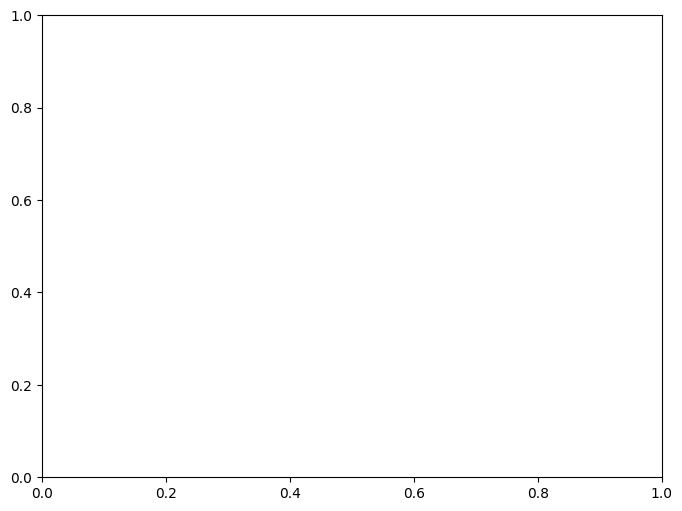

In [121]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px

fig, ax = plt.subplots(figsize=(8, 6))

summary_plot = summary.copy()

dates = summary_plot['article_date'].astype(str).values
 
fig1 = px.line(summary_plot, x="article_date", y=summary_plot.columns[2:4])
fig1.update_layout(xaxis=dict(showgrid=False, zeroline=False),
              yaxis=dict(showgrid=False, zeroline=False), template="presentation",
              xaxis_title="", yaxis_title="", legend_title="", title="Mentions of Palestinian and Israeli Deaths by the BBC",
              plot_bgcolor='wheat',
              paper_bgcolor='wheat'

)
fig1.show()
